In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [249]:
data = pd.read_csv("project_data.csv")

In [250]:
#Select known columns for initial modeling
#age, day of week, employment, marriage-status, month, school, successful_sell

data_subset = data[['age','dow','employment','marriage-status','month','school','successful_sell']]

In [17]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              41188 non-null  int64 
 1   dow              41188 non-null  object
 2   employment       41188 non-null  object
 3   marriage-status  41108 non-null  object
 4   month            41188 non-null  object
 5   school           39457 non-null  object
 6   successful_sell  41188 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.2+ MB


In [251]:
#Missing values for school and marriage-status.
#Filter rows with missing values.
#School is an ordinal variable. May not be missing at random, but <5% of data.
#marriage-status could be handled with additional category
#Some models such as xgboost can handle missing values
data_subset = data_subset.dropna()

In [19]:
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39386 entries, 0 to 41187
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39386 non-null  int64 
 1   dow              39386 non-null  object
 2   employment       39386 non-null  object
 3   marriage-status  39386 non-null  object
 4   month            39386 non-null  object
 5   school           39386 non-null  object
 6   successful_sell  39386 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.4+ MB


In [20]:
data_subset['successful_sell'].value_counts()

successful_sell
no     35007
yes     4379
Name: count, dtype: int64

### Data Preparation

In [252]:
#Train-Test Split of data
X = data_subset[['age','dow','marriage-status','month','school']]
y = data_subset[['successful_sell']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [253]:
#Encode columns appropriately on training data
#Day of week - one hot
#Employment - one hot
#marriage status - one hot
#month - one hot
#school - ordinal 

#One hot encode categorical variables
cat_cols = ['dow','marriage-status','month']

#Fit one hot encoder
oh_encoder = OneHotEncoder(sparse_output=False)
oh_encoder.fit(X_train[cat_cols])

#Apply to train data
encoded_data = oh_encoder.transform(X_train[cat_cols])
oh_encoded_train_df = pd.DataFrame(encoded_data, columns = oh_encoder.get_feature_names_out(cat_cols))
oh_encoded_train_df.set_index(X_train.index, inplace=True)

#Ordinal encode school var

ord_cols = ['school']
ord_encoder = OrdinalEncoder(categories =[['0 - none','1 - almost none','2 - a little bit','3 - a bit more',
                                             '4 - average amount','5 - a decent amount', '5 - a lot',]])
ord_encoder.fit(X_train[ord_cols])
ord_encoded_train_data = ord_encoder.transform(X_train[ord_cols])

#combine train data
X_train_transform = X_train[['age']]
X_train_transform = pd.concat([X_train_transform, oh_encoded_train_df], axis = 1 )
X_train_transform['school'] = ord_encoded_train_data


#Test Data

#Apply one hot encoding to test data
encoded_data = oh_encoder.transform(X_test[cat_cols])
oh_encoded_test_df = pd.DataFrame(encoded_data, columns = oh_encoder.get_feature_names_out(cat_cols))
oh_encoded_test_df.set_index(X_test.index, inplace=True)

#Apply ord encoding
ord_encoded_test_data = ord_encoder.transform(X_test[ord_cols])

#Combine Test Data
X_test_transform = X_test[['age']]
X_test_transform = pd.concat([X_test_transform, oh_encoded_test_df], axis = 1 )
X_test_transform['school'] = ord_encoded_test_data

In [254]:
#encode outcome

#Train
lab_encoder = LabelEncoder()
lab_encoder.fit(y_train['successful_sell'])
encoded_label = lab_encoder.transform(y_train['successful_sell'])
y_train_transform = y_train
y_train_transform['sale'] = encoded_label
y_train_transform.drop('successful_sell',axis=1, inplace=True)

# Test
encoded_label = lab_encoder.transform(y_test['successful_sell'])
y_test_transform = y_test
y_test_transform['sale'] = encoded_label
y_test_transform.drop('successful_sell',axis=1, inplace=True)

### Logistic Regression

In [110]:
#Train Logistic Baseline Model
logreg = LogisticRegression(random_state=16, max_iter=200)
logreg.fit(X_train_transform, y_train_transform['sale'])

LogisticRegression(max_iter=200, random_state=16)

In [194]:
y_pred = logreg.predict_proba(X_test_transform)

In [195]:
#Format Output
y_test_pred = y_test
y_test_pred['pred'] = y_pred[::,1]

In [268]:
#Calculate Test AUC
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test_pred['sale'], y_test_pred['pred'])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
print(roc_auc_lr)

0.6639585171223816


<Axes: xlabel='pred', ylabel='Count'>

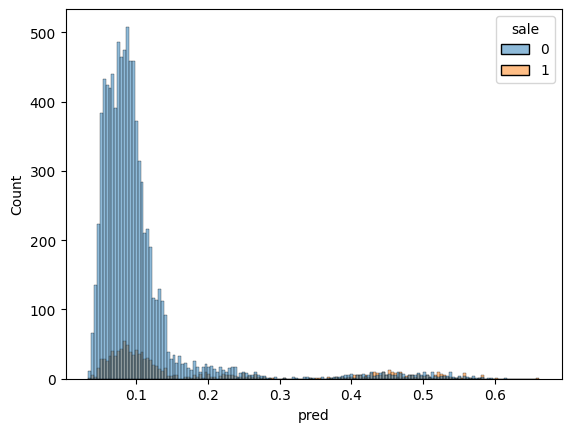

In [133]:
sns.histplot(data=y_test_pred, x="pred", hue="sale")

### XGBooost

In [272]:
#Train tuned XGB classifier, CV and Random Search

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for random search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1,3,5,7,9]
}

# Create a scorer for AUC
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True, response_method = 'predict_proba')

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=40,
    scoring=auc_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
)


In [273]:
# Fit the random search
random_search.fit(X_train_transform, y_train_transform)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1, 3, 5, 7, 9],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, response_method='predict_proba'))

In [274]:
# Get the best model and its score
best_model1 = random_search.best_estimator_
best_score1 = random_search.best_score_
best_params1 = random_search.best_params_

print(best_score1)
print(best_params1)

0.7013931526215809
{'subsample': 0.5, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

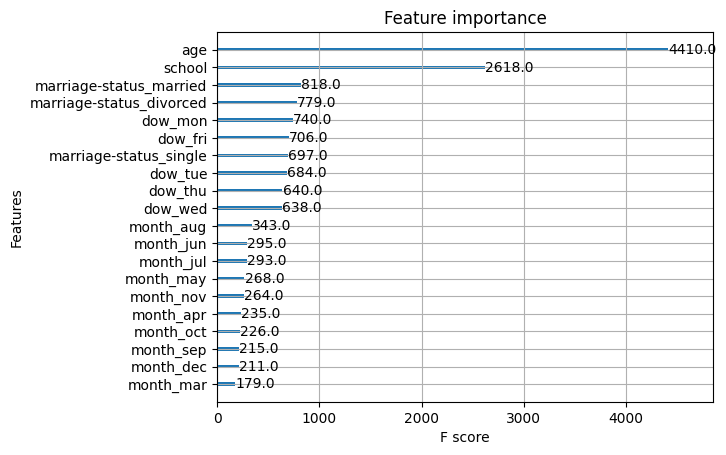

In [258]:
xgb.plot_importance(best_model1)

In [259]:
# Make predictions with best model
y_pred_test_x = best_model1.predict_proba(X_test_transform)

In [260]:
#Format output
y_test_pred_x = y_test
y_test_pred_x['pred'] = y_pred_test_x[::,1]

In [265]:
#Deciles Function
def decile_table(df):
    df['decile'] = pd.qcut(df['pred'], 10, labels=False)
    summary = df.groupby('decile')['sale'].agg(['count', 'sum'])
    summary['precision'] = summary['sum']/summary['count'] 
    summary['recall'] = summary['sum']/summary['sum'].sum() 
    return summary

In [266]:
decile_table(y_test_pred_x)

,count,sum,precision,recall
decile,,,,
0,986,46,0.046653,0.041108
1,986,59,0.059838,0.052726
2,982,74,0.075356,0.066130
3,986,78,0.079108,0.069705
4,984,73,0.074187,0.065237
5,984,68,0.069106,0.060769
6,985,94,0.095431,0.084004
7,986,94,0.095335,0.084004
8,984,138,0.140244,0.123324


<Axes: xlabel='pred', ylabel='Count'>

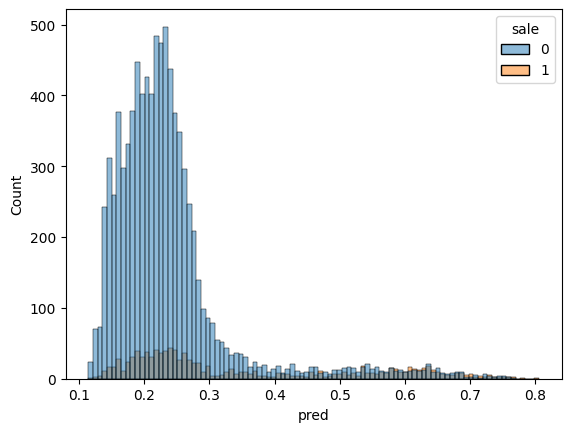

In [157]:
sns.histplot(data=y_test_pred, x="pred", hue="sale")

In [158]:
#Caluculate AUC
fpr, tpr, thresholds = metrics.roc_curve(y_test_pred_x['sale'], y_test_pred_x['pred'])
roc_auc = metrics.auc(fpr, tpr)

In [159]:
print(roc_auc)

0.6986455515063944


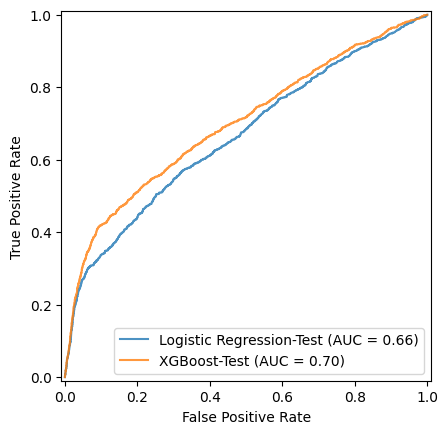

In [238]:
#Plot ROC curves for comparing LR and XGB
ax = plt.gca()

display1 = metrics.RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr, roc_auc=roc_auc_lr,
                                  estimator_name='Logistic Regression-Test')

display2 = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBoost-Test')

display1.plot(ax=ax, alpha=0.8)
display2.plot(ax=ax, alpha=0.8)


## Exploratory Model

In [177]:
# select additional unknown variables to add to model
data_subset_ex = data[['age','dow','employment','marriage-status','month','school','c4','c8','n2','n6','successful_sell']]

In [178]:
data_subset_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              41188 non-null  int64 
 1   dow              41188 non-null  object
 2   employment       41188 non-null  object
 3   marriage-status  41108 non-null  object
 4   month            41188 non-null  object
 5   school           39457 non-null  object
 6   c4               41188 non-null  object
 7   c8               5625 non-null   object
 8   n2               41188 non-null  int64 
 9   n6               41188 non-null  int64 
 10  successful_sell  41188 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.5+ MB


In [179]:
#for column c8, fill nan with 'uknown' to create additional category
data_subset_ex.loc[pd.isna(data_subset_ex['c8']) , 'c8'] = 'unknown'

In [202]:
#Filter na for school and marriage status for consistency with previous models
#We could leave these as unknown as we will only be fitting an xgb model which can handle missing values
data_subset_ex = data_subset_ex.dropna()

In [205]:
#Train-Test Split of data
X = data_subset_ex[['age','dow','marriage-status','month','school','c4','c8','n2','n6']]
y = data_subset_ex[['successful_sell']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

In [220]:
#Encode columns appropriately on training data
#Day of week - one hot
#Employment - one hot
#marriage status - one hot
#month - one hot
#school - ordinal 

#c4 - binary(use ord)
#c8 - one hot

#One hot encode categorical variables
cat_cols = ['dow','marriage-status','month','c8']

#Fit one hot encoder
oh_encoder = OneHotEncoder(sparse_output=False)
oh_encoder.fit(X_train[cat_cols])

#Apply to train data
encoded_data = oh_encoder.transform(X_train[cat_cols])
oh_encoded_train_df = pd.DataFrame(encoded_data, columns = oh_encoder.get_feature_names_out(cat_cols))
oh_encoded_train_df.set_index(X_train.index, inplace=True)

#Ordinal encode school var

ord_cols = ['school','c4']
ord_encoder = OrdinalEncoder(categories =[['0 - none','1 - almost none','2 - a little bit','3 - a bit more',
                                             '4 - average amount','5 - a decent amount', '5 - a lot'],['old','new']])
ord_encoder.fit(X_train[ord_cols])
ord_encoded_train_data = ord_encoder.transform(X_train[ord_cols])
ord_encoded_train_data_df = pd.DataFrame(ord_encoded_train_data, columns = ['school','c4'])
ord_encoded_train_data_df.set_index(X_train.index, inplace=True)

#combine train data
X_train_transform = X_train[['age','n2','n6']]
X_train_transform = pd.concat([X_train_transform, oh_encoded_train_df], axis = 1 )
X_train_transform = pd.concat([X_train_transform, ord_encoded_train_data_df], axis = 1 )


#Test Data

#Apply one hot encoding to test data
encoded_data = oh_encoder.transform(X_test[cat_cols])
oh_encoded_test_df = pd.DataFrame(encoded_data, columns = oh_encoder.get_feature_names_out(cat_cols))
oh_encoded_test_df.set_index(X_test.index, inplace=True)

#Apply ord encoding
ord_encoded_test_data = ord_encoder.transform(X_test[ord_cols])
ord_encoded_test_data_df = pd.DataFrame(ord_encoded_test_data, columns = ['school','c4'])
ord_encoded_test_data_df.set_index(X_test.index, inplace=True)

#Combine Data
X_test_transform = X_test[['age','n2','n6']]
X_test_transform = pd.concat([X_test_transform, oh_encoded_test_df], axis = 1 )
X_test_transform = pd.concat([X_test_transform, ord_encoded_test_data_df], axis = 1 )

In [223]:
#encode outcome

#Train
lab_encoder = LabelEncoder()
lab_encoder.fit(y_train['successful_sell'])
encoded_label = lab_encoder.transform(y_train['successful_sell'])
y_train_transform = y_train
y_train_transform['sale'] = encoded_label
y_train_transform.drop('successful_sell',axis=1, inplace=True)

# Test
encoded_label = lab_encoder.transform(y_test['successful_sell'])
y_test_transform = y_test
y_test_transform['sale'] = encoded_label
y_test_transform.drop('successful_sell',axis=1, inplace=True)

In [275]:
#Train tuned XGB classifier, CV and Random Search

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Define the parameter grid for random search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1,3,5,7,9]
}

# Create a scorer for AUC
auc_scorer = metrics.make_scorer(metrics.roc_auc_score, greater_is_better=True, response_method = 'predict_proba')

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_grid,
    n_iter=40,
    scoring=auc_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
)

In [225]:
# Fit the random search to your data
random_search.fit(X_train_transform, y_train_transform)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [1, 3, 5, 7, 9],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, response_method='predict_proba'))

In [226]:
best_model = random_search.best_estimator_
best_score = random_search.best_score_
best_params = random_search.best_params_

print(best_score)
print(best_params)

0.7673326532937598
{'subsample': 0.5, 'scale_pos_weight': 3, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.5}


In [231]:
# Make predictions with best model
y_preds_ex = best_model.predict_proba(X_test_transform)

In [232]:
#Format data
y_pred_test_ex = y_test
y_pred_test_ex['pred'] = y_preds_ex[::,1]

In [233]:
#Calculate FPR,TPR,AUC for this model
fpr_ex, tpr_ex, thresholds_ex = metrics.roc_curve(y_pred_test_ex['sale'], y_pred_test_ex['pred'])
roc_auc_ex = metrics.auc(fpr_ex, tpr_ex)

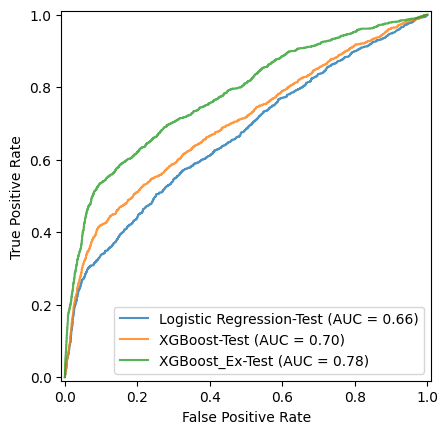

In [236]:
#Plot ROC curves for all 3 models

ax = plt.gca()

display1 = metrics.RocCurveDisplay(fpr=fpr_lr, tpr=tpr_lr, roc_auc=roc_auc_lr,
                                  estimator_name='Logistic Regression-Test')

display2 = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBoost-Test')

display3 = metrics.RocCurveDisplay(fpr=fpr_ex, tpr=tpr_ex, roc_auc=roc_auc_ex,
                                  estimator_name='XGBoost_Ex-Test')

display1.plot(ax=ax, alpha=0.8)
display2.plot(ax=ax, alpha=0.8)
display3.plot(ax=ax, alpha=0.8)

<Axes: xlabel='pred', ylabel='Count'>

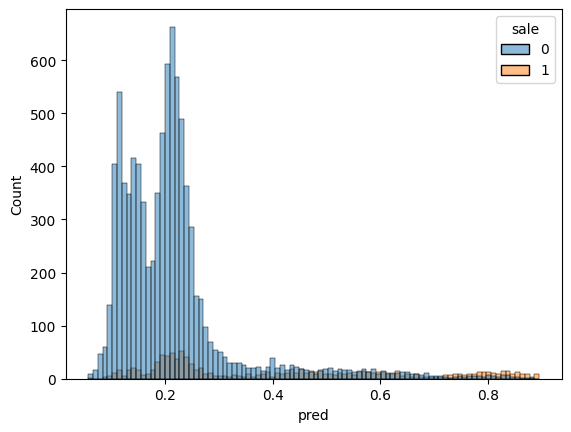

In [239]:
sns.histplot(data=y_pred_test_ex, x="pred", hue="sale")

In [267]:
#Deciles
decile_table(y_pred_test_ex)

,count,sum,precision,recall
decile,,,,
0,985,27,0.027411,0.024129
1,986,33,0.033469,0.029491
2,983,39,0.039674,0.034853
3,985,53,0.053807,0.047364
4,985,77,0.078173,0.068811
5,985,68,0.069036,0.060769
6,985,79,0.080203,0.070599
7,983,89,0.090539,0.079535
8,985,163,0.165482,0.145666


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

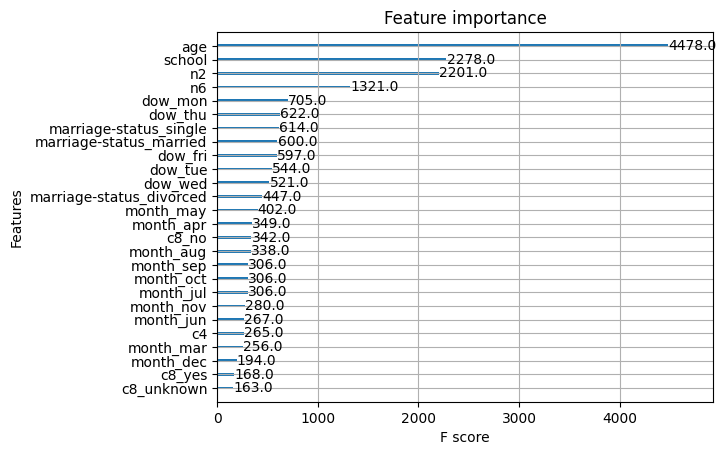

In [248]:
xgb.plot_importance(best_model)